# Testing the ability to distinguish signal events from background

In [36]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [37]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

### Record (Raw) Wire Features 

In [38]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Signal like or not (apriori)
sig_like = numpy.vstack(hits.get_prob_sig_wire(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [39]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Prepare Neighbour Features

In [40]:
Neighbours = hits.cydet.point_neighbours

# Sum of energy desposits of neighbours 
sum_neigh_deposits = Neighbours.dot(deposits.T).T
# Sum of neighbouring neighbour deposits (smoothed clustering)
sum_neigh_deposits_2 = Neighbours.dot(sum_neigh_deposits.T).T
# wires pick up their own value, subtract it back out
sum_neigh_deposits_2 -= deposits 
# Number of neighbours with hits
num_neigh_deposits = Neighbours.dot(deposits.T > 0).T

### Left/Right Neighbour Features

In [41]:
LRNeighbours = hits.cydet.lr_neighbours
# Sum of energy desposits of left/right neighbours 
sum_lr_deposits = LRNeighbours.dot(deposits.T).T
# Sum of left/right neighbouring left/right neighbour deposits
sum_lr_deposits_2 = LRNeighbours.dot(sum_neigh_deposits.T).T
sum_lr_deposits_2 -= deposits # wires pick up their own value twice, subtract it back out
# Number of neighbours with hits
num_lr_deposits = LRNeighbours.dot(deposits.T > 0).T
# Sum of relative timing of left/right neighbours
sum_lr_time = LRNeighbours.dot(rel_time.T).T

## Train/test splitting 

In [42]:
from sklearn.cross_validation import train_test_split

# Take train_events out for GBDT wire-level training, set aside the rest that will be used
wire_trn_evts, most_events = train_test_split(range(len(labels)), train_size=0.10, test_size=0.55)

# Take train_events out for GBDT training, set aside the rest that will be used
train_events, rest_events = train_test_split(most_events, train_size=0.27)

# Designate part of the rest as GBDT training, with the remainder as final testing
test_events, final_tst_evts = train_test_split(rest_events, train_size=0.375)

# Note that the test events for GBDT can be used as training events for the final algorithm
final_trn_evts = test_events

## Label all features for Pandas data frame

In [43]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id
# Neighbour Features
features['sum_neigh_deposits'] = sum_neigh_deposits * 100
features['num_neigh_deposits'] = num_neigh_deposits 
features['sum_neigh_deposits_2'] = sum_neigh_deposits_2 * 100
# Left-Right neighbour features
features['sum_lr_time'] = sum_lr_time
features['sum_lr_deposits'] = sum_lr_deposits * 100
features['num_lr_deposits'] = num_lr_deposits 
features['sum_lr_deposits_2'] = sum_lr_deposits_2 * 100
# Truth values
features['labels'] = labels

In [44]:
# Name train features as all featurs except label
train_features = features.keys()[:-1]

In [45]:
# Name data as all features stacked in 3D array
data = numpy.dstack(features.values())

In [46]:
import pandas
# Count the number of features
data.shape
n_feats = data.shape[-1]

# Undertrained Wire-Level GBDT Algorithm

In [47]:
# Define a small portion of the data to be used as a 0th order guess of if the wire is a signal or not
wire_trn_data = data[wire_trn_evts].reshape(-1, n_feats)
wire_trn_data = pandas.DataFrame(data=wire_trn_data, columns=features.keys())
wire_tst_data = data[test_events].reshape(-1, n_feats)
wire_tst_data = pandas.DataFrame(data=wire_tst_data, columns=features.keys())

In [48]:
# Purge cells with no hits out
wire_trn_data = wire_trn_data[wire_trn_data['labels'] != 0]
wire_tst_data = wire_tst_data[wire_tst_data['labels'] != 0]

# Define signal hit as 1, background hit as 0
wire_trn_data['labels'] = 2 - wire_trn_data['labels']
wire_tst_data['labels'] = 2 - wire_tst_data['labels']

In [49]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [50]:
factory = ClassifiersFactory()

wire_features = ['deposit', 'rel_time', 'layer_id']

# Define GBDT over wire features
gb_wire_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=10), 
                                    features=wire_features)

# Define GBDT over only energy deposit to compare
gb_deposit = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=['deposit'])
factory.add_classifier('Wire Features', gb_wire_features)
factory.add_classifier('Energy Deposit', gb_deposit)

In [51]:
# Train the classifier
factory.fit(wire_trn_data, wire_trn_data['labels'])
pass

model Wire Features was trained in 2.59 seconds
model Energy Deposit was trained in 9.75 seconds
Totally spent 12.34 seconds on training


In [52]:
# Test the classifier
wire_predictions = factory.test_on(wire_tst_data, wire_tst_data['labels'])

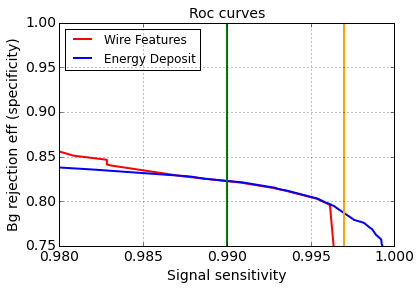

In [53]:
roc = wire_predictions.roc()
roc.plot(xlim=[0.98,1.], ylim=[0.75,1.])
plt.plot([.99, .99], [0.75, 1.], 'k-', lw=2,  c='g' )
plt.plot([.997, .997], [0.75, 1.], 'k-', lw=2,c='orange')

In [54]:
# Take only the all features GBDT from here on out
wire_gbdt = factory['Wire Features']
LRNeighbours = hits.cydet.lr_neighbours
Neighbours = hits.cydet.point_neighbours

def add_sig_like_features(data):
    #Apply to the data frame
    wire_gbdt_out = wire_gbdt.predict_proba(data)

    # Take only the signal probability
    wire_gbdt_out = wire_gbdt_out[:,1]

    # Define which wires were unhit.
    final_unhit = (data['labels'] == 0).values

    # Set all wires with no hits to negative weight
    wire_gbdt_out[final_unhit] = 0.

    # Reshape wires by event, i.e. reshape so that each event has cydent.n_points
    wire_gbdt_out = wire_gbdt_out.reshape(-1,hits.cydet.n_points)
    
    # Number of signal-like neighbours
    data['sig_like_lr'] = LRNeighbours.dot(wire_gbdt_out.T).T.flatten()
    data['sig_like_neigh'] = Neighbours.dot(wire_gbdt_out.T).T.flatten()

# Main GBDT Algorithm

In [55]:
# Define the test/train data for the GBDT
train_data, test_data = data[train_events].reshape(-1, n_feats), data[test_events].reshape(-1, n_feats)
# Define these data sets as panda frames
train_data = pandas.DataFrame(data=train_data, columns=features.keys())
test_data = pandas.DataFrame(data=test_data, columns=features.keys())

## Use the results of the loose fit

In [56]:
add_sig_like_features(train_data)
add_sig_like_features(test_data)
train_features += ['sig_like_lr', 'sig_like_neigh']

## Prepare data for GBDT

In [57]:
# Purge cells with no hits out
train_data = train_data[train_data['labels'] != 0]
test_data = test_data[test_data['labels'] != 0]

# Define signal hit as 1, background hit as 0
train_data['labels'] = 2 - train_data['labels']
test_data['labels'] = 2 - test_data['labels']

## Using simple GBRT to determine if wire is signal

In [58]:
# Define GBDT over all features
gb_all_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
factory.add_classifier('All Features', gb_all_features)
factory.add_classifier('Energy Deposit', gb_deposit)

In [59]:
# Train the classifier
factory.fit(train_data, train_data['labels'])
pass

model Wire Features was trained in 4.63 seconds
model Energy Deposit was trained in 15.95 seconds
model All Features was trained in 88.66 seconds
Totally spent 109.25 seconds on training


In [60]:
# Test the classifier
predictions = factory.test_on(test_data, test_data['labels'])

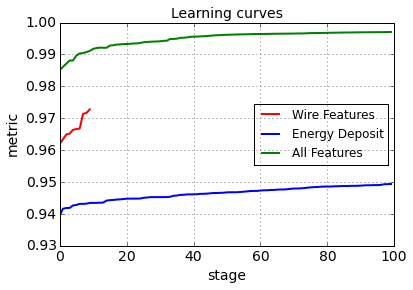

In [61]:
# Look at learning curve
predictions.learning_curve(RocAuc(), steps=1)

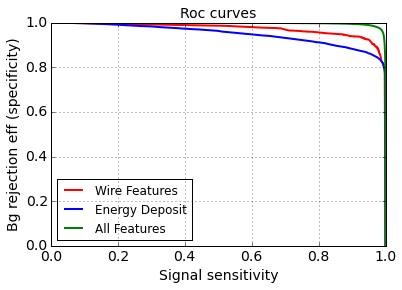

In [62]:
roc = predictions.roc()
roc.plot()

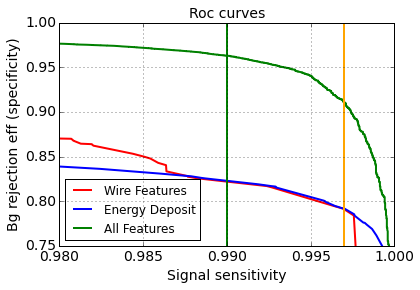

In [63]:
roc.plot(xlim=[0.98,1.], ylim=[0.75,1.])
plt.plot([.99, .99], [0.75, 1.], 'k-', lw=2,  c='g' )
plt.plot([.997, .997], [0.75, 1.], 'k-', lw=2,c='orange')

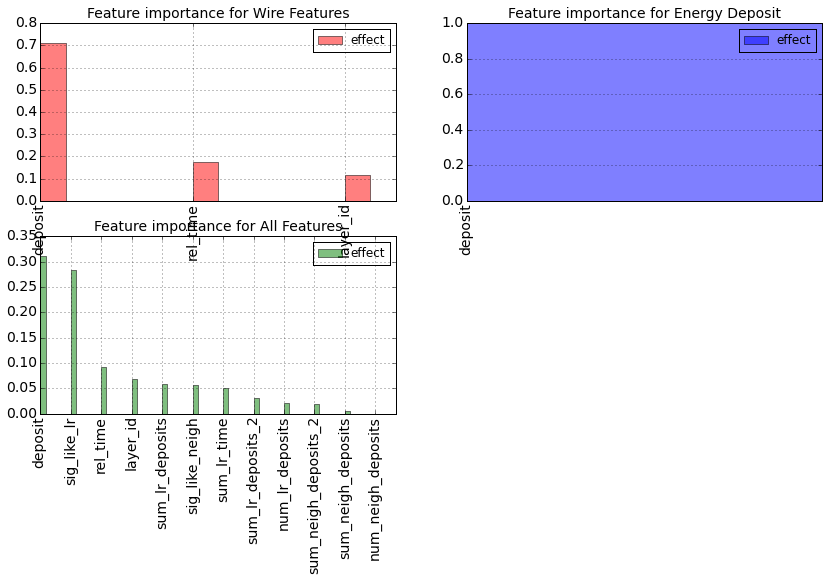

In [64]:
predictions.feature_importance().plot(figsize=[14, 7])

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


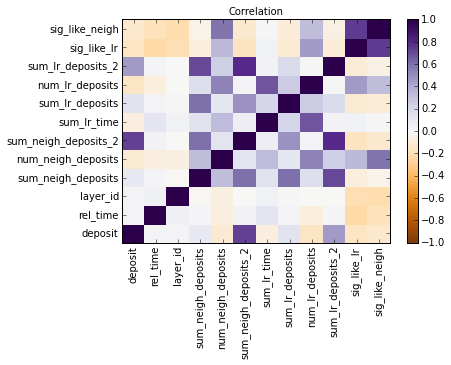

In [65]:
corr = predictions.features_correlation_matrix(features=train_features)
corr.cmap = "PuOr"
corr.plot()

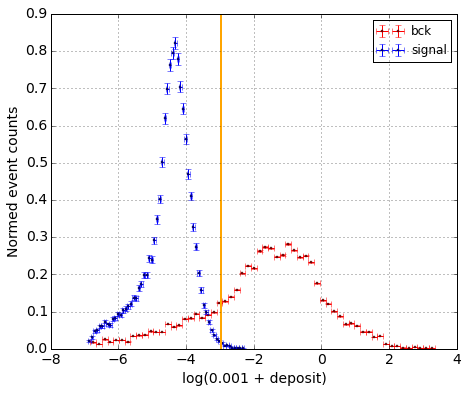

In [66]:
dep = predictions.features_pdf(features=['log(0.001 + deposit)'], bins=60)
dep.plot()
plt.plot([log(0.001+0.05), log(0.001+0.05)], [0, 0.9], 'k-', lw=2, c='orange')

### Measure Effectiveness of GBDT

In [67]:
#n_bins = 10
#bin_width = 1./n_bins
#p = predictions.prediction['All Features'][:, 1]
#fpr, tpr, thresholds = roc_curve(test_data['labels'], p)
#signal_weight = 

#limits = numpy.percentile(p, [10, 20, 30, 40, 50, 60, 70, 80, 90])
#bin_indices = numpy.searchsorted(limits, p)
#s = numpy.bincount(bin_indices, weight=signal_weight)
#b = numpy.bincount(bin_indices, weight=bck_weight)
#result = numpy.sum(s * s / (b + regularization))

# Perform the Hough Transform

In [122]:
from tracking import Hough
from sklearn.preprocessing import normalize
from scipy.sparse import vstack
from sklearn.metrics import roc_auc_score

hough = Hough(hits,rho_bins=20, sig_rho_min=31.5, sig_rho=34, sig_rho_max=34.5, sig_rho_sgma=2)

##Prepare the data

In [139]:
# Define the train/test data for the final algorithm
final_trn_data, final_tst_data = data[final_trn_evts].reshape(-1, n_feats),\
                                 data[final_tst_evts].reshape(-1, n_feats)
final_trn_data = pandas.DataFrame(data=final_trn_data, columns=features.keys())
final_tst_data = pandas.DataFrame(data=final_tst_data, columns=features.keys())
add_sig_like_features(final_trn_data)
add_sig_like_features(final_tst_data)

# Take only the all features GBDT from here on out
gbdt = factory['All Features']

# Apply to the final training data
gbdt_out = gbdt.predict_proba(final_trn_data)

# Take only the signal probability
gbdt_out = gbdt_out[:,1]

# Define which wires were unhit.
final_unhit = (final_trn_data['labels'] == 0).values

# Randomize output of GBDT 
fake_predictions = numpy.random.exponential(0.1 + gbdt_out, size=gbdt_out.shape)

# Set all wires with no hits to negative weight
gbdt_out[final_unhit] = 0
fake_predictions[final_unhit] -= 0

# Reshape wires by event, i.e. reshape so that each event has cydent.n_points
gbdt_out = gbdt_out.reshape(-1,hits.cydet.n_points)
fake_predictions = fake_predictions.reshape(-1,hits.cydet.n_points)

## Prepare the transform

In [140]:
# Find the even and odd layer wires in the cydet
even_wires = where(hits.cydet.point_pol != 1)[0]
odd_wires = where(hits.cydet.point_pol == 1)[0]

# Define the even and odd hough transforms as only acting on even or odd layers
hough_even_forward = hough.correspondence.T
hough_odd_forward = hough.correspondence.T
hough_even_forward[:,odd_wires] = 0
hough_odd_forward[:,even_wires] = 0

# Define inverses
hough_even_inverse = hough_even_forward.T.copy()
hough_odd_inverse = hough_odd_forward.T.copy()

# Stack these two contirbutions into one matrix of shape [n_track_centers*2, n_wires]
#hough_even_odd = vstack([hough_even_forward,hough_odd_forward])

# Acquire the forward hough transform as the hough transform bisected by even and odd
# layers.  Define the reverse hough transform indepedenetly to this
#hough_forward = hough_even_odd
#hough_inverse = hough_even_odd.T.copy()
hough_orig =  hough.correspondence.T.copy()

#hough_orig = normalize(hough_orig, norm='l1', axis=1)
#hough_forward = normalize(hough_forward, norm='l2', axis=1)

hough_even_forward = normalize(hough_even_forward, norm='l1', axis=1)
hough_odd_forward = normalize(hough_odd_forward, norm='l1', axis=1)

def prepare_hough(wire_probabilities, alpha=2.):
    """
    Alpha defines scaling of expontent in reweighting procedure
    """
    # Apply the forward hough transforms to all events 
    # This defines the probability of a track center
    #hough_out = hough_forward.dot(wire_probabilities.T).T
    hough_even_out = hough_even_forward.dot(wire_probabilities.T).T
    hough_odd_out = hough_odd_forward.dot(wire_probabilities.T).T
    
    # TODO: normalize in hough space on even odd, then reweight, then invert, then combine?
    
    # Probability due to fitting even and odd must be reweighted first
    hough_even_out_rw = numpy.exp(alpha * hough_even_out.T)
    hough_odd_out_rw = numpy.exp(alpha * hough_odd_out.T)    
    
    # Now we can combine the two
    #hough_out_both = hough_out_rw[:hough.track.n_points] + hough_out_rw[hough.track.n_points:]
    hough_out_both = hough_odd_out_rw + hough_even_out_rw
    
    # Apply the inverse hough transform to the exponentiated hough transform out put
    # This weights track points closer to the tracks as more likely
    hough_even_inv_out = hough_even_inverse.dot(hough_even_out_rw).T
    hough_odd_inv_out = hough_odd_inverse.dot(hough_odd_out_rw).T
    
    return hough_even_inv_out, hough_odd_inv_out, hough_odd_out_rw.T, hough_even_out_rw.T

### Randomize output of GBDT to test output of Hough

In [141]:
# Relabel nothig as 2, background as 0, signal as 1
true_labels = 2 - final_trn_data['labels']
true_labels = true_labels.values.flatten()

# Label hit wires as not 2
hit_wires = true_labels != 2

# Weight the hits missed by the GBDT as higher
mislabel_weight = abs(true_labels - gbdt_out.flatten())**2

print "Area under ROC curve after noise ", roc_auc_score(true_labels[hit_wires],\
                                           fake_predictions.flatten()[hit_wires],\
                                           sample_weight=mislabel_weight[hit_wires])

Area under ROC curve after noise  0.296755456363


### Preform Parameter Scan over Alpha

In [142]:
alpha_min = 9.0
alpha_max = 13.0
n_alphas = 40
d_alpha = (alpha_max - alpha_min)/n_alphas
alphas = np.zeros(n_alphas)
tpr_hough = np.zeros(n_alphas)
fpr_hough = np.zeros(n_alphas)

for this_alpha in range(n_alphas):
    alpha_try = alpha_min + d_alpha*this_alpha
    # generating fake predictions based on gbdt. Probably there is more appropriate distibution

    hough_even_pred, hough_odd_pred, _ , _ = prepare_hough(fake_predictions, alpha_try)
    hough_even_pred = hough_even_pred.flatten()
    hough_odd_pred = hough_odd_pred.flatten()

    hough_predictions = hough_even_pred/np.amax(hough_even_pred) +\
                        hough_odd_pred/np.amax(hough_odd_pred)
    
    alphas[this_alpha] = alpha_try
    tpr_hough[this_alpha] = roc_auc_score(true_labels[hit_wires], hough_predictions[hit_wires],\
                                          sample_weight=mislabel_weight[hit_wires])
    print alpha_try, tpr_hough[this_alpha]

9.0 0.807671796779
9.1 0.808396928901
9.2 0.809068549669
9.3 0.809736054736
9.4 0.810404211323
9.5 0.811052559149
9.6 0.811710866351
9.7 0.812290911316
9.8 0.812964732195
9.9 0.81343926933
10.0 0.813985844687
10.1 0.814291951854
10.2 0.814817189447
10.3 0.815453854293
10.4 0.810482445301
10.5 0.810609738452
10.6 0.810816739634
10.7 0.810974804237
10.8 0.811332758429
10.9 0.811501513498
11.0 0.811884257298
11.1 0.812300820993
11.2 0.812419942186
11.3 0.813147853986
11.4 0.81315996384
11.5 0.813885903022
11.6 0.813439735079
11.7 0.814735228475
11.8 0.813537909463
11.9 0.813543806804
12.0 0.811344473568
12.1 0.81034887045
12.2 0.812062099202
12.3 0.810164620566
12.4 0.810449041004
12.5 0.811076057674
12.6 0.808609129055
12.7 0.80974496815
12.8 0.807764714137
12.9 0.808716277717


In [143]:
print alphas[ where(tpr_hough == max(tpr_hough)) ]
best_alpha = alphas[ np.where(tpr_hough == max(tpr_hough))][0]

[ 10.3]


## Comparing the quality of inital quess vs after the Hough transform

In [144]:
alpha_try = best_alpha

hough_even_pred, hough_odd_pred, _ , _ = prepare_hough(fake_predictions, alpha_try)

hough_even_pred = hough_even_pred.flatten()
hough_odd_pred = hough_odd_pred.flatten()

hough_predictions = hough_even_pred/np.amax(hough_even_pred) +\
                        hough_odd_pred/np.amax(hough_odd_pred)

mislabel_weight = abs(true_labels - gbdt_out.flatten())**2

print "Signal retention after noise ", roc_auc_score(true_labels[hit_wires],\
                                       fake_predictions.flatten()[hit_wires],\
                                       sample_weight=mislabel_weight[hit_wires])
print "Signal retention after hough ",roc_auc_score(true_labels[hit_wires],\
                                     hough_predictions[hit_wires],\
                                    sample_weight=mislabel_weight[hit_wires])

Signal retention after noise  0.296755456363
Signal retention after hough  0.815453854293


### Observe effect of re-weighting in hough space

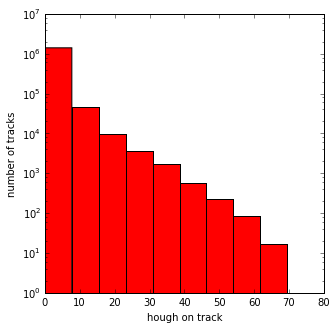

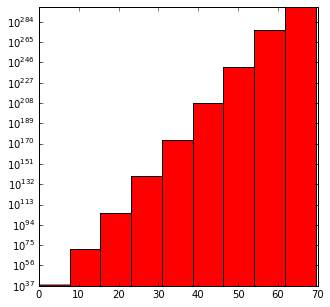

In [145]:
figsize(5,5)
hough_out = hough_orig.dot(gbdt_out.T).T
hist(hough_out.flatten(), log=True)
xlabel('hough on track')
ylabel('number of tracks')
show()
alpha_try = best_alpha
# if we use alpha=alpha_try, then contribution will look ole this: 
hist(hough_out.flatten(), log=True, weights=numpy.exp(alpha_try * hough_out.flatten()))
show()

# Hough Predictions vs. GBDT out

In [146]:
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85)   
rhos, phis = hits.cydet.get_points_rhos_and_phis()
xs, ys = hits.cydet.get_points_xs_and_ys()
t_rhos, t_phis = hough.track.get_points_rhos_and_phis()
t_xs, t_ys = hough.track.get_points_xs_and_ys()

In [147]:
test_alpha = best_alpha
hough_preds_even_evt, hough_preds_odd_evt, wght_hough_even_out, wght_hough_odd_out = prepare_hough(gbdt_out, test_alpha)
hough_out = hough_orig.dot(gbdt_out.T).T

In [148]:
vis_event = 3

# Get the predictions
hough_preds_even = hough_preds_even_evt[vis_event]
hough_preds_odd = hough_preds_odd_evt[vis_event]
gbdt_preds = gbdt_out[vis_event]
track_preds_even = wght_hough_even_out[vis_event]
track_preds_odd = wght_hough_odd_out[vis_event]
track_orig = hough_out[vis_event]

# Get the index corresponding to the full set of events
evt = test_events[vis_event]

sig = hits.get_sig_wires(evt)
bkg = hits.get_bkg_wires(evt)

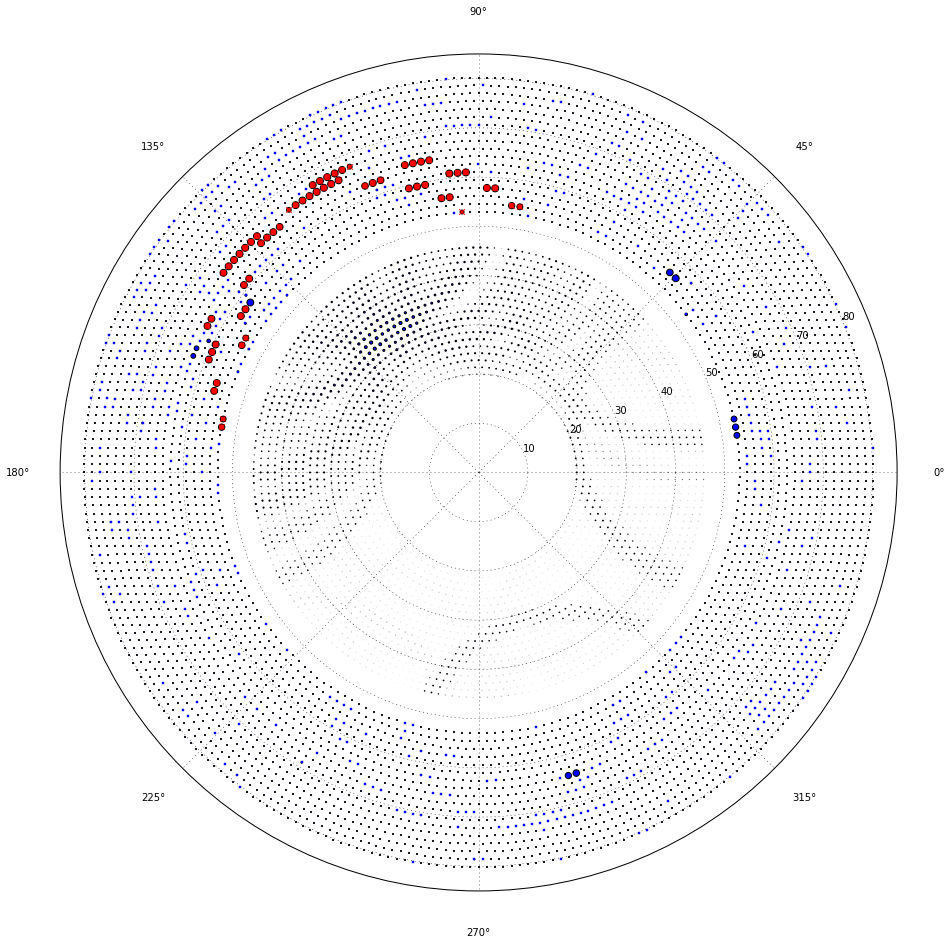

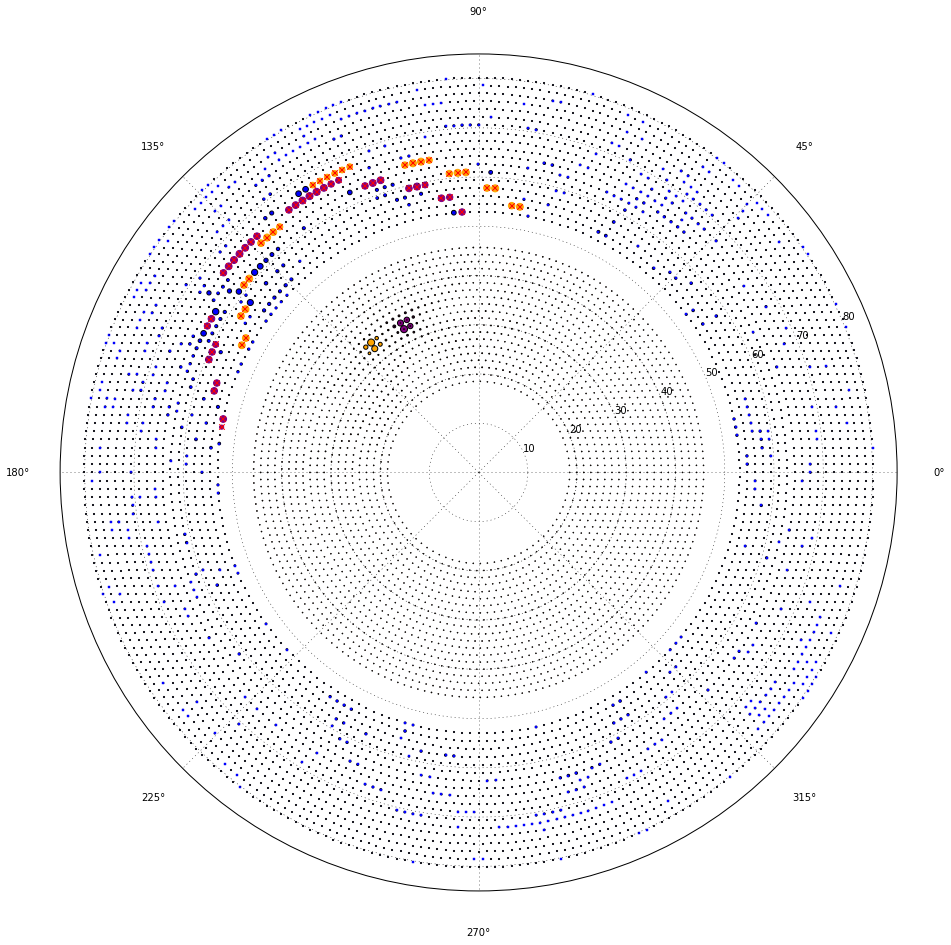

In [149]:
## Output of GBDT/before reweighting
setup_plot_for_detector()
ax = plt.subplot(111, polar=True)
ax.scatter(phis, rhos, marker='.', s=5)
ax.scatter(t_phis,t_rhos,10*track_orig/max(track_orig),marker='o', c='b') 
ax.scatter(phis[sig],rhos[sig], 50*gbdt_preds[sig]/max(gbdt_preds), marker='o', c='r')
ax.scatter(phis[bkg],rhos[bkg], 50*gbdt_preds[bkg]/max(gbdt_preds), marker='o', c='b')
ax.scatter(phis[sig],rhos[sig], s=30, marker='x', c='r')
ax.scatter(phis[bkg],rhos[bkg], s=5, marker='x', c='b')
show()

## Output with hough transform
setup_plot_for_detector()
ax = plt.subplot(111, polar=True)
ax.scatter(phis, rhos, marker='.', s=5)

ax.scatter(t_phis ,t_rhos, 50*track_preds_even/max(track_preds_even), marker='o', c='purple') 
ax.scatter(t_phis ,t_rhos, 50*track_preds_odd/max(track_preds_odd), marker='o', c='orange') 

ax.scatter(phis[sig],rhos[sig], 50*hough_preds_even[sig]/max(hough_preds_even), marker='o', color="purple")
ax.scatter(phis[sig],rhos[sig], 50*hough_preds_odd[sig]/max(hough_preds_odd), marker='o', color='orange')
ax.scatter(phis[bkg],rhos[bkg], 50*hough_preds_even[bkg]//max(hough_preds_even), marker='o', c='b')
ax.scatter(phis[bkg],rhos[bkg], 50*hough_preds_odd[bkg]//max(hough_preds_odd), marker='o', c='b')
ax.scatter(phis[sig],rhos[sig], s=30, marker='x', c='r')
ax.scatter(phis[bkg],rhos[bkg], s=5, marker='x', c='b')
show()

# Combining GBDT and Hough Transform information

## Apply Local GBDT to the training and testing data

In [150]:
# Take only the all features GBDT from here on out
gbdt = factory['All Features']

# Apply to the final training data and final testing data
final_trn_gbdt = gbdt.predict_proba(final_trn_data)
final_tst_gbdt = gbdt.predict_proba(final_tst_data)

# Take only the signal probability
final_trn_gbdt = final_trn_gbdt[:,1]
final_tst_gbdt = final_tst_gbdt[:,1]

# Define which wires were unhit.
final_trn_unhit = (final_trn_data['labels'] == 0).values
final_tst_unhit = (final_tst_data['labels'] == 0).values

# Set all wires with no hits to zero
final_trn_gbdt[final_trn_unhit] = 0
final_tst_gbdt[final_tst_unhit] = 0

# Add this output as a as feature
final_trn_data['Local_GBDT'] = final_trn_gbdt
final_tst_data['Local_GBDT'] = final_tst_gbdt

## Apply Hough to train and test data

In [151]:
# Reshape wires by event, i.e. reshape so that each event has cydent.n_points
final_trn_gbdt = final_trn_gbdt.reshape(-1,hits.cydet.n_points)
final_tst_gbdt = final_tst_gbdt.reshape(-1,hits.cydet.n_points)

#Perform the hough transform over these
final_alpha = best_alpha
final_trn_hough_even, final_trn_hough_odd, _, _  = prepare_hough(final_trn_gbdt, final_alpha)
final_tst_hough_even, final_tst_hough_odd, _, _ = prepare_hough(final_tst_gbdt, final_alpha)

# Add the flattened ouput as a feature
final_trn_data['Hough'] = final_trn_hough_even.flatten() + final_trn_hough_odd.flatten()
final_tst_data['Hough'] = final_tst_hough_even.flatten() + final_tst_hough_odd.flatten()

# Add the flattened ouput as a feature
final_trn_data['Hough_Even'] = final_trn_hough_even.flatten()
final_tst_data['Hough_Even'] = final_tst_hough_even.flatten()

# Add the flattened ouput as a feature
final_trn_data['Hough_Odd'] = final_trn_hough_odd.flatten()
final_tst_data['Hough_Odd'] = final_tst_hough_odd.flatten()


# Add the polarity of the wire as a feature, i.e. denote if its on an even or odd layer
polarity = numpy.vstack(hits.cydet.point_pol for i in range(hits.n_events))
final_trn_data['Polarity'] = polarity[final_trn_evts].flatten()
final_tst_data['Polarity'] = polarity[final_tst_evts].flatten()

## Prepare data for GBDT

In [152]:
# Purge cells with no hits out
final_trn_data = final_trn_data[final_trn_data['labels'] != 0]
final_tst_data = final_tst_data[final_tst_data['labels'] != 0]

# Define signal hit as 1, background hit as 0
final_trn_data['labels'] = 2 - final_trn_data['labels']
final_tst_data['labels'] = 2 - final_tst_data['labels']

## Define and add final GBDT to the factory list

In [153]:
final_factory = ClassifiersFactory()

# Define features to be used in final GBDT
final_train_features = train_features + ['Hough']
final_train_features_split = train_features + ['Hough_Even','Hough_Odd', 'Polarity']


# Define GBDT over all features, including Hough
gb_final = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), features=final_train_features) 
# Define GBDT over all features, including Hough
gb_final_split = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), features=final_train_features_split) 

# Define GBDT over previous features, double the number of trees to faily compare to final
gb_all_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                                    features=train_features)
# Define GBDT over only energy deposit, double the number of trees to faily compare to final
gb_deposit = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])
final_factory.add_classifier('Final Decision', gb_final)
final_factory.add_classifier('Final Decision Split', gb_final_split)
final_factory.add_classifier('Previous GBDT', gb_all_features)
final_factory.add_classifier('Energy Only', gb_deposit)

In [154]:
# Train the classifier
final_factory.fit(final_trn_data, final_trn_data['labels'])
pass

model Final Decision was trained in 100.37 seconds
model Final Decision Split was trained in 108.55 seconds
model Previous GBDT was trained in 187.10 seconds
model Energy Only  was trained in 30.65 seconds
Totally spent 426.68 seconds on training


In [155]:
# Test the classifier
final_predictions = final_factory.test_on(final_tst_data, final_tst_data['labels'])

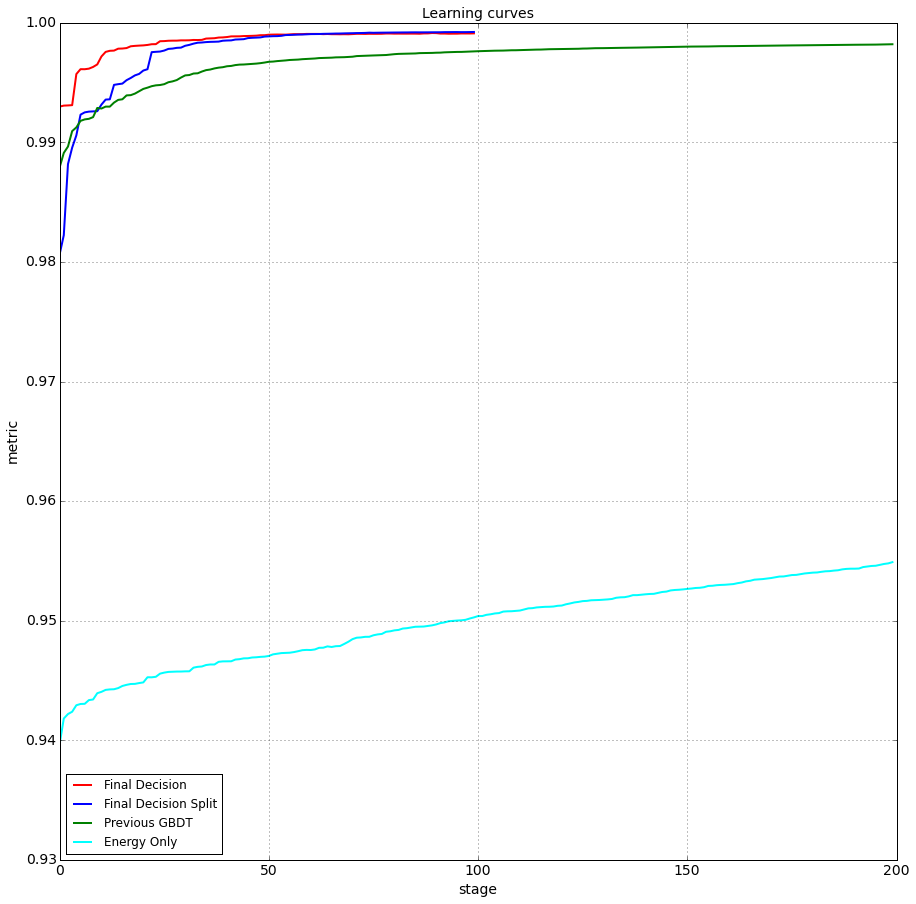

In [156]:
# Look at learning curves
final_predictions.learning_curve(RocAuc(), steps=1)

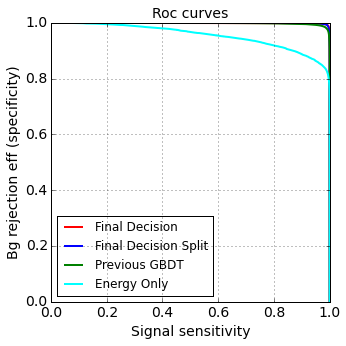

In [157]:
figsize(5,5)
roc = final_predictions.roc()
roc.plot()

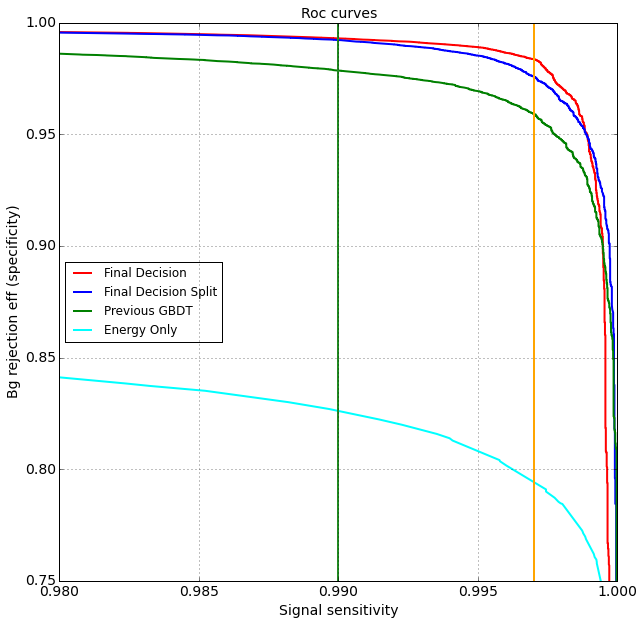

In [162]:
figsize(10,10)
roc.plot(xlim=[0.98,1.], ylim=[0.75,1.])
plt.plot([.99, .99], [0.75, 1.], 'k-', lw=2,  c='forestgreen' )
plt.plot([.997, .997], [0.75, 1.], 'k-', lw=2,c='orange')

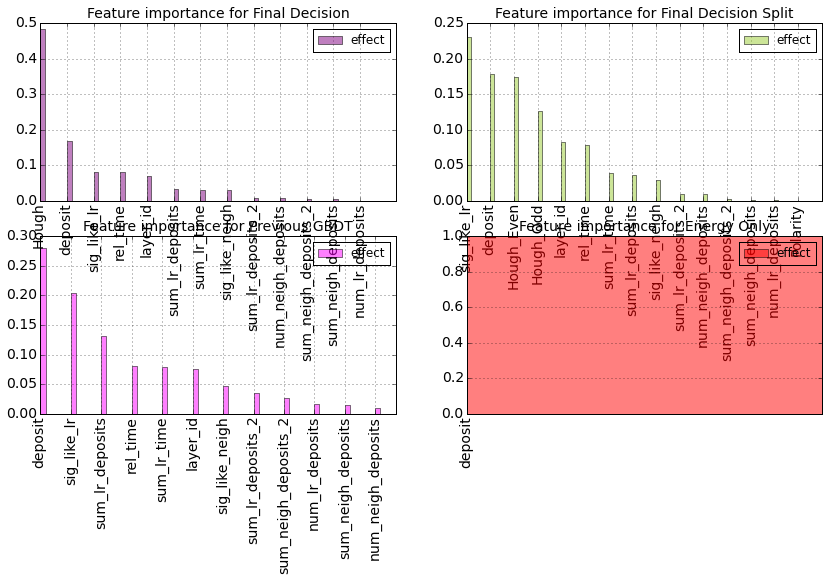

In [159]:
final_predictions.feature_importance().plot(figsize=[14, 7])

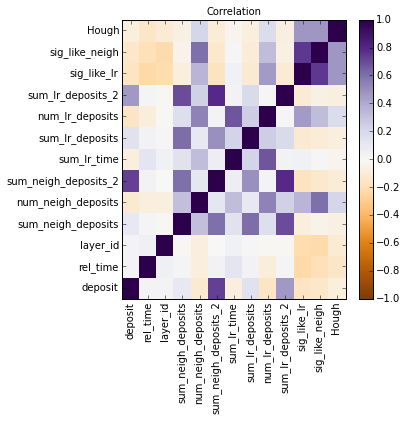

In [160]:
corr = final_predictions.features_correlation_matrix(features=final_train_features)
corr.cmap = "PuOr"
corr.plot()

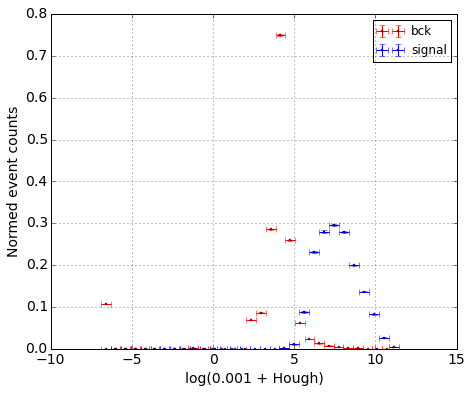

In [161]:
final_predictions.features_pdf(features=['log(0.001 + Hough)'])

In [163]:
n_sig = 0 
n_sig_pass = 0
n_bkg = 0 
n_bkg_pass = 0
for evt in range(hits.n_events):
        sig_wires = hits.get_sig_wires(evt)
        sig_wires_pass = where(hits.get_energy_deposits(evt)[sig_wires] < 0.000005)[0]
        n_sig += len(sig_wires)
        n_sig_pass += len(sig_wires_pass)
        
        bkg_wires = hits.get_bkg_wires(evt)
        bkg_wires_pass = where(hits.get_energy_deposits(evt)[bkg_wires] < 0.000005)[0]
        n_bkg += len(bkg_wires)
        n_bkg_pass += len(bkg_wires_pass)
print "Signal Retention Rate {}".format(n_sig_pass/float(n_sig))
print "Background Rejection Rate {}".format(n_bkg_pass/float(n_bkg))

# Save these values for comparison later
tpr_orig = n_sig_pass/float(n_sig)
fpr_orig = n_bkg_pass/float(n_bkg)

Signal Retention Rate 0.99706385438
Background Rejection Rate 0.20393287988


In [168]:
from sklearn.metrics import roc_curve
new_tpr = 0.99
new_fpr = 0.10
tpr_orig_index =  where(tpr > tpr_orig)[0][1]
fpr_orig_index =  where(fpr > fpr_orig)[0][1]

tpr_new_index =  where(tpr > new_tpr)[0][1]
fpr_new_index =  where(fpr > new_fpr)[0][1]

print "At signal retetion rate at 5 KeV cut, {0:.5f} , background regjection has changed from".format(tpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_orig_index],fpr_orig-fpr[tpr_orig_index]) + \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_orig_index]))
print "At background retetion rate at 5 KeV cut, {0:.5f} , signal retention has changed from".format(1-fpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_orig_index], tpr[fpr_orig_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_orig_index]))

print "At new signal retention of {0:.5f}, background regjection has changed from".format(new_tpr) + \
      "\n{0:.5f} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_new_index], fpr_orig-fpr[tpr_new_index])+ \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_new_index]))
print "At new background rejection rate of {0:.5f}, signal retention has changed from".format(new_fpr) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_new_index], tpr[fpr_new_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_new_index]))


ValueError: too many values to unpack